# MNIST Image Classification with TensorFlow

This notebook demonstrates how to implement a simple linear image model on MNIST data set using `tf.keras`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import shutil
import os
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
print(tf.__version__)

Instructions for updating:
non-resource variables are not supported in the long term
2.4.1


## Exploring the data

In [2]:
HEIGHT = 28
WIDTH = 28
NCLASSES = 10

# Get MNIST data
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Scale features between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert labels to categorical one-hot encoding
y_train = tf.keras.utils.to_categorical(y=y_train, num_classes=NCLASSES)
y_test = tf.keras.utils.to_categorical(y=y_test, num_classes=NCLASSES)

print("x_train.shape = {}".format(x_train.shape))
print("y_train.shape = {}".format(y_train.shape))
print("x_test.shape = {}".format(x_test.shape))
print("y_test.shape = {}".format(y_test.shape))

x_train.shape = (60000, 28, 28)
y_train.shape = (60000, 10)
x_test.shape = (10000, 28, 28)
y_test.shape = (10000, 10)


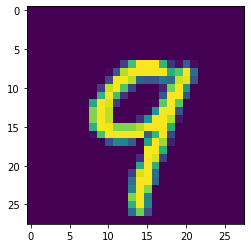

In [3]:
IMGNO = 12
plt.imshow(x_test[IMGNO].reshape(HEIGHT, WIDTH));

## Define the model

Let's start with a very simple linear classifier. All our models will have this basic interface $-$ they will take an image and return probabilities.

In [8]:
# Build Keras model using Keras Sequential API
def linear_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=[HEIGHT, WIDTH], name="image"))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=NCLASSES, activation=tf.nn.softmax, name="probabilities"))
    return model

## Write input functions

As usual, we need to define input functions for training, test/evaluation, and serving/prediction.

In [5]:
# Create training input function
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"image": x_train},
    y=y_train,
    batch_size=100,
    num_epochs=None,
    shuffle=True,
    queue_capacity=5000
)

# Create evaluation input function
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"image": x_test},
    y=y_test,
    batch_size=100,
    num_epochs=1,
    shuffle=False,
    queue_capacity=5000
)

# Create serving input function for inference
def serving_input_fn():
    placeholders = {"image": tf.placeholder(dtype=tf.float32, shape=[None, HEIGHT, WIDTH])}
    features = placeholders # as is
    return tf.estimator.export.ServingInputReceiver(features=features, receiver_tensors=placeholders)

## Create `train_and_evaluate` function

`tf.estimator.train_and_evaluate` carries out the distributed training

In [6]:
def train_and_evaluate(output_dir, hparams):
    # Build Keras model
    model = linear_model()
    
    # Compile Keras model with optimiser, loss function, and eval metrics
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"])
    
    # Convert Keras model to a tf.estimator.Estimator()
    estimator = tf.keras.estimator.model_to_estimator(
        keras_model=model,
        model_dir=output_dir)
    
    # Set estimator's tf.estimator.TrainSpec() to use train_input_fn and train
    train_spec = tf.estimator.TrainSpec(
        input_fn=train_input_fn,
        max_steps=hparams["train_steps"])
    
    # Create exporter that uses serving_input_fn() to create saved_model for serving
    exporter = tf.estimator.LatestExporter(
        name="exporter",
        serving_input_receiver_fn=serving_input_fn)
    
    # Set estimator's tf.estimator.EvalSpec() to use eval_input_fn and export saved_model
    eval_spec = tf.estimator.EvalSpec(
        input_fn=eval_input_fn,
        steps=None,
        exporters=exporter)
    
    # Run tf.estimator.train_and_evaluate() loop
    tf.estimator.train_and_evaluate(
        estimator=estimator,
        train_spec=train_spec,
        eval_spec=eval_spec)

This is the `main()` function

In [9]:
OUTDIR = "mnist/learned"
shutil.rmtree(OUTDIR, ignore_errors=True) # Start fresh each time

hparams = {"train_steps": 1000,
           "learning_rate": 0.01}
train_and_evaluate(OUTDIR, hparams)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


/home/antounes/.local/lib/python3.8/site-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


INFO:tensorflow:Using config: {'_model_dir': 'mnist/learned', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed

/home/antounes/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


INFO:tensorflow:Inference Time : 0.50730s
INFO:tensorflow:Finished evaluation at 2021-06-15-18:41:35
INFO:tensorflow:Saving dict for global step 1000: acc = 0.9136, global_step = 1000, loss = 0.32051563
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: mnist/learned/model.ckpt-1000
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Restoring parameters from mnist/learned/model.ckpt-1000
INFO:tensorflow:Asse